# Thick Sample Ptychography Sample Tutorial 3D

Tutorial to show how to construct or load a sample space and visualise.

### 1. Import Libraries: Sample Space


In [8]:
from thickptypy.sample_space.sample_space import SampleSpace

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

In [9]:
bc_type = "impedance"               # Boundary condition type 
probe_type = "disk"                 # Airy disk probe
wave_number = 1e4  # Wave number

# Continuous space limits (micrometers)
xlims = [0, 1000]                    # X limits in micrometers
ylims = [0, 1000]                    # Y limits in micrometers
zlims = [0, 20]

# Continuous space parameters
continuous_dimensions = [
    xlims, 
    ylims, 
    zlims
    ]                     # Continuous dimensions in micrometers

# Discrete space parameters
propagation_slices = 20              # Number of z slices
probe_dimensions = [32, 32]         # Detector shape can be different from discrete_dimensions
probe_diameter = 20                 # Diameter if using initial condition "disk"
scan_points = 30                     # Single probe
step_size = 4                     # Step size in pixels


# Discrete space limits (pixels)
min_nx = int(scan_points * step_size + probe_dimensions[0])
min_ny = int(scan_points * step_size + probe_dimensions[1])
print(f"Pixels for compatibility with Diamond thin-sample simulation:")
print(f"nx = {min_nx} and ny = {min_ny}")
print(f"(These are also the minimum values for the discrete space limits)")

nx, ny = 50, 50          # Number of pixels in x and y directions
if nx < min_nx:
    nx = min_nx
if ny < min_ny:
    ny = min_ny
discrete_dimensions = [
    nx, 
    ny, 
    propagation_slices
    ]   

Pixels for compatibility with Diamond thin-sample simulation:
nx = 152 and ny = 152
(These are also the minimum values for the discrete space limits)


### 3. Create Sample Space

Initialize the sample space. The sample space dimensions are defined here as well
as it's discritization in pixels. The subdimensions

Summary of the scan (continuous):
    Sample space x: 1000 um
    Sample space y: 1000 um
    Sample space z: 20 um
    Probe Diameter: 132.45 um
    Number of scan points: 900
    Max Overlap: 106.13 um 



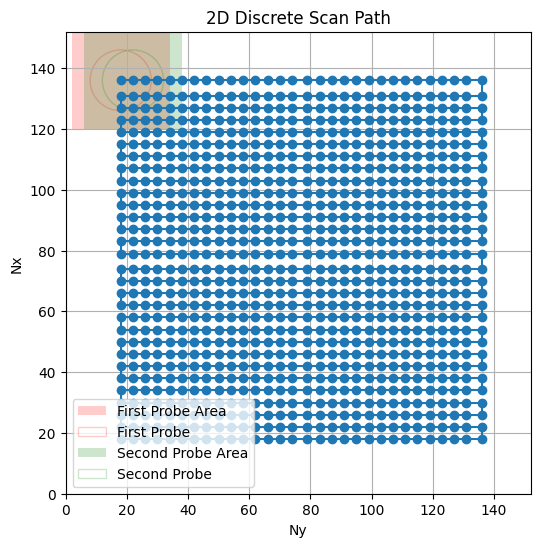

In [10]:
sample_space = SampleSpace(
    continuous_dimensions, # sample space dimensions in nanometers (x, z) or (x, y, z)
    discrete_dimensions,   # sample space dimensions in pixels (nx, nz) or (nx, ny, nz)
    probe_dimensions,        # shape of the detector in pixels - subset of (nx) or (nx, ny)
    scan_points,           # number of ptychography scan points or sqrt(scan_points) for square scan
    step_size,
    bc_type,               # boundary condition type (impedance, dirichlet, neumann)
    probe_type,
    wave_number,            # wavenumber in 1/nm
    probe_diameter=probe_diameter
)
sample_space.summarize_sample_space()

### 4. Add Objects and Visualize Sample Space

Add cubiods, prisms or cylinders with specified refractive indices to the sample space.

In [11]:
# Add objects to the sample space and generate it
# Refractive index: 1 + e-4 + e-6i
delta = 1e-4
beta = 1e-6j
refractive_index_pertubation1 = delta + beta
refractive_index_pertubation2 = 0.99*delta + beta
guassian_blur = 0.0 # removes sharp edges in the refractive index perturbation
sample_space.add_object('prism', refractive_index_pertubation1, side_length=0.3*xlims[1],
                         centre=(xlims[1]*0.65, xlims[1]*0.65, zlims[1]*0.5),
                         depth=zlims[1]*0.8,guassian_blur=guassian_blur)
sample_space.add_object('cuboid', refractive_index_pertubation2, side_length=0.2*xlims[1],
                        centre=(xlims[1]*0.4, xlims[1]*0.4, zlims[1]*0.5),
                        depth=zlims[1]*0.8,guassian_blur=guassian_blur)

sample_space.generate_sample_space()

In [12]:
# Import Visualisation module
from thickptypy.utils.visualisations import Visualisation

visualisation = Visualisation(sample_space=sample_space)

# Visualise the Sample Space
visualisation.plot(solution=sample_space.n_true, slider=True, title=" (Sample Space Refractive Index)")

interactive(children=(IntSlider(value=0, description='slice', max=19), Output()), _dom_classes=('widget-intera…

### 4. Load and Visualize Sample Space

In [ ]:
# Alternatively, load in your own sample space
filepath = "./data/simulated_spheres_128.npy"
sample_space.load_sample_space(filepath)

### 5. Solve the Forward Model

Solve the forward problem both iteratively and as a full system for sub-samples
and the full sample.

In [14]:
# Solve Full Space
thin_sample = True
forward_model_iterative_thin = ForwardModel(sample_space, thin_sample=thin_sample)

# Iterative solution
print("Solving iteratively for thin sample...")
solution_iterative_thin = forward_model_iterative_thin.solve(verbose=True)

NameError: name 'ForwardModel' is not defined

In [ ]:
if nx <= 80 and ny <= 80 and propagation_slices <= 20:
    # Solve Full Space
    thin_sample = False
    full_system = False
    forward_model = ForwardModel(sample_space, thin_sample=thin_sample, 
                                 full_system_solver=full_system)

    # Iterative solution
    print("Solving iteratively for full sample...")
    solution_iterative_solve_full = forward_model.solve(verbose=True)

else:
    print("Skipping full space solution for large sample space dimensions (nx, ny > 50, nz > 20).")


Skipping full space solution for large sample space dimensions (nx, ny > 50, nz > 20).


### 6. Solve in Reverse

The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

**To do:**
 - fix this for full system.
 - complete the test

In [ ]:
# # Set Exit wave to initial condition for reverse
# print("Solving iteratively for thin sample in reverse...")
# initial_condition = solution_iterative_thin[..., -1].copy()  # Copy the last frame of the solution
# solution_iterative_thin_reverse = forward_model_iterative_thin.solve(reverse=True,
#                                                       initial_condition=initial_condition,
#                                                       verbose=True)

# import numpy as np
# # Compute RMSE between solution_iterative_solve_thin_reverse and itself
# rmse = np.sqrt(np.mean(np.abs(solution_iterative_thin[..., 0] - solution_iterative_thin_reverse[..., -1]) ** 2))
# print(f"RMSE between forward and backward solutions: {rmse}")

### 8. Visualisation of Solutions

Module to help view solutions.

In [ ]:
# Plotting the solution for thin sample
if scan_points <= 12:
    visualisation.plot(solution=solution_iterative_thin)
visualisation.plot(solution=solution_iterative_thin, slider=True, probe_index=257)

interactive(children=(IntSlider(value=0, description='slice', max=19), Output()), _dom_classes=('widget-intera…

In [ ]:
# Plot Solution for Full Sample Solves
if nx <= 80 and ny <= 80 and propagation_slices <= 20:
    visualisation.plot(solution=solution_iterative_solve_full)
    visualisation.plot(solution=solution_iterative_solve_full, slider=True, probe_index=0)
else:
    print("Skipping full space solution visualisation for large sample space dimensions (nx, ny > 50, nz > 20).")

Skipping full space solution visualisation for large sample space dimensions (nx, ny > 50, nz > 20).


### 7. Save thin sample data to Tiff Files for Ptychography Reconstructions

In [ ]:
import tifffile as tiff
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

save_dir = Path("./results")
save_dir.mkdir(exist_ok=True)

# Save the data as a numpy file
exit_waves = solution_iterative_thin[:,:,:,-1]  # Get the exit waves from the solution
data = np.zeros_like(exit_waves, dtype=np.float32)

for frame_number in range(sample_space.num_probes):
    data[frame_number, :, :] = np.random.poisson(np.square(np.abs(np.fft.fftshift(np.fft.fft2(exit_waves[frame_number, :, :])))))
np.save(save_dir / 'data.npy', data)

# Save the object field cross section as a tif file
object_field_cross_section = sample_space.n_true[:, :, int(sample_space.nz / 2)]
object_field_cross_section = np.flipud(object_field_cross_section)
object_field_cross_section_modulus = np.abs(object_field_cross_section).astype(np.float32) 
object_field_cross_section_phase = np.angle(object_field_cross_section).astype(np.float32) 
tiff.imwrite(save_dir / 'object_field_cross_section_phase.tif', object_field_cross_section_phase)
object_field_cross_section = np.flipud(object_field_cross_section)
tiff.imwrite(save_dir / 'object_field_cross_section_modulus.tif', object_field_cross_section_modulus)

# Save the parameters as a json file
if bc_type == "dirichlet":
    probe_dimensions = [probe_dimensions[0]+2, probe_dimensions[1]+2]

parameters = {
    "detector_shape": probe_dimensions,
    "probe_diameter": probe_diameter,
    "scan_step_size": step_size,
    "scan_points_xy": scan_points
}

with open(save_dir / 'parameters.json', 'w') as json_file:
    json.dump(parameters, json_file)

/tmp/ipykernel_124850/657074572.py:28: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(data[frame_number, :, :]), cmap='gray', origin='lower')


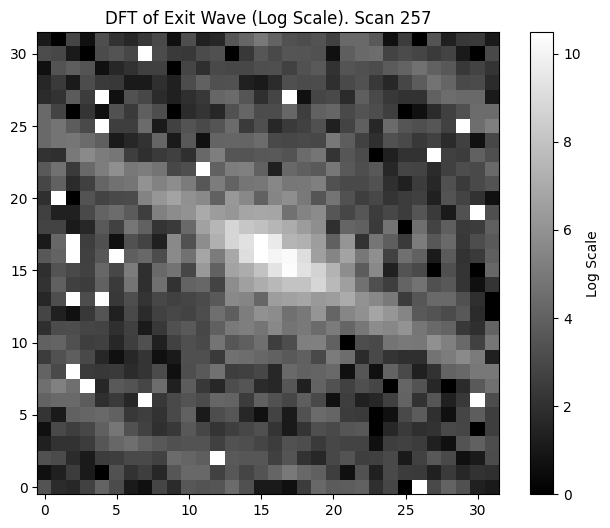

In [ ]:
def plot_data(data, scan_points_xy):
    fig_re, axes_re = plt.subplots(scan_points_xy, scan_points_xy, figsize=(15, 12), squeeze=False)

    num_probes = data.shape[0]  # Number of frames

    for idx in range(num_probes):
        row = idx // scan_points_xy
        if row % 2 == 0:  # Even row (left to right)
            col = idx % scan_points_xy
        else:  # Odd row (right to left)
            col = scan_points_xy - 1 - ( idx % scan_points_xy )

        im_r = axes_re[row, col].imshow(np.log(data[idx, :, :]), cmap='gray',origin='lower')
        axes_re[row, col].set_title(f'Scan {idx+1}')

    fig_re.suptitle('Data Frames: DFT of Exit Wave (Log Scale)', fontsize=16)
    plt.show()

def plot_single_frame(data, frame_number):
    """
    Plot a single frame of the data.
    
    Parameters:
    - data: numpy array containing the data
    - frame_number: index of the frame to plot
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(np.log(data[frame_number, :, :]), cmap='gray', origin='lower')
    plt.title(f'DFT of Exit Wave (Log Scale). Scan {frame_number + 1}')
    plt.colorbar(label='Log Scale')
    plt.show()

# Example usage
if scan_points <= 12:
    plot_data(data, scan_points)  # Adjust scan_points_xy as needed
plot_single_frame(data, 256)